In [16]:
"""
Lynden-Bell Luminosity function
-------------------------------
Figure 4.10.

An example of computing the luminosity function for two u-r color-selected
subsamples of SDSS galaxies using Lynden-Bell's C- method. The galaxies are
selected from the SDSS spectroscopic sample, with redshift in the range
0.08 < z < 0.12 and flux limited to r < 17.7. The left panels show the
distribution of sources as a function of redshift and absolute magnitude. The
distribution p(z, M) = rho(z) Phi(m) is obtained using Lynden-Bell's method,
with errors determined by 20 bootstrap resamples. The results are shown in the
right panels. For the redshift distribution, we multiply the result by z^2 for
clarity. Note that the most luminous galaxies belong to the photometrically
red subsample, as discernible in the bottom-right panel.
"""

"\nLynden-Bell Luminosity function\n-------------------------------\nFigure 4.10.\n\nAn example of computing the luminosity function for two u-r color-selected\nsubsamples of SDSS galaxies using Lynden-Bell's C- method. The galaxies are\nselected from the SDSS spectroscopic sample, with redshift in the range\n0.08 < z < 0.12 and flux limited to r < 17.7. The left panels show the\ndistribution of sources as a function of redshift and absolute magnitude. The\ndistribution p(z, M) = rho(z) Phi(m) is obtained using Lynden-Bell's method,\nwith errors determined by 20 bootstrap resamples. The results are shown in the\nright panels. For the redshift distribution, we multiply the result by z^2 for\nclarity. Note that the most luminous galaxies belong to the photometrically\nred subsample, as discernible in the bottom-right panel.\n"

In [17]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from __future__ import print_function, division
import os
import numpy as np
from matplotlib import pyplot as plt

from scipy import interpolate
from astropy.cosmology import FlatLambdaCDM

from astroML.lumfunc import bootstrap_Cminus
from astroML.datasets import fetch_sdss_specgals

In [18]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec

In [19]:
N=10
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

In [21]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


In [28]:
# to enlarge the sizes
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# Get the data and perform redshift/magnitude cuts

In [29]:
#------------------------------------------------------------
# Get the data and perform redshift/magnitude cuts
data = fetch_sdss_specgals()

z_min = 0.08
z_max = 0.12
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > z_min]
data = data[data['z'] < z_max]
data = data[data['petroMag_r'] < m_max]

# divide red sample and blue sample based on u-r color

In [30]:
# divide red sample and blue sample based on u-r color
ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

In [31]:
# truncate sample (optional: speeds up computation)
#data_red = data_red[::10]
#data_blue = data_blue[::10]
print(data_red.size, "red galaxies")
print(data_blue.size, "blue galaxies")

114152 red galaxies
45010 blue galaxies


# Distance Modulus calculation:

In [32]:
#------------------------------------------------------------
# Distance Modulus calculation:
#  We need functions approximating mu(z) and z(mu)
#  where z is redshift and mu is distance modulus.
#  We'll accomplish this using the cosmology class and
#  scipy's cubic spline interpolation.
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=0)
z_sample = np.linspace(0.01, 1.5, 100)
mu_sample = cosmo.distmod(z_sample).value
mu_z = interpolate.interp1d(z_sample, mu_sample)
z_mu = interpolate.interp1d(mu_sample, z_sample)

data = [data_red, data_blue]
titles = ['$u-r > 2.22$', '$u-r < 2.22$']
markers = ['o', '^']
archive_files = ['lumfunc_red.npz', 'lumfunc_blue.npz']

In [33]:
def compute_luminosity_function(z, m, M, m_max, archive_file):
    """Compute the luminosity function and archive in the given file.

    If the file exists, then the saved results are returned.
    """
    Mmax = m_max - (m - M)
    zmax = z_mu(m_max - M)

    if not os.path.exists(archive_file):
        print("- computing bootstrapped luminosity function ",
              "for {0} points".format(len(z)))

        zbins = np.linspace(0.08, 0.12, 21)
        Mbins = np.linspace(-24, -20.2, 21)
        dist_z, err_z, dist_M, err_M = bootstrap_Cminus(z, M, zmax, Mmax,
                                                        zbins, Mbins,
                                                        Nbootstraps=20,
                                                        normalize=True)
        np.savez(archive_file,
                 zbins=zbins, dist_z=dist_z, err_z=err_z,
                 Mbins=Mbins, dist_M=dist_M, err_M=err_M)
    else:
        print("- using precomputed bootstrapped luminosity function results")
        archive = np.load(archive_file)
        zbins = archive['zbins']
        dist_z = archive['dist_z']
        err_z = archive['err_z']
        Mbins = archive['Mbins']
        dist_M = archive['dist_M']
        err_M = archive['err_M']

    return zbins, dist_z, err_z, Mbins, dist_M, err_M

# Perform the computation and plot the results

- using precomputed bootstrapped luminosity function results
- using precomputed bootstrapped luminosity function results


/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


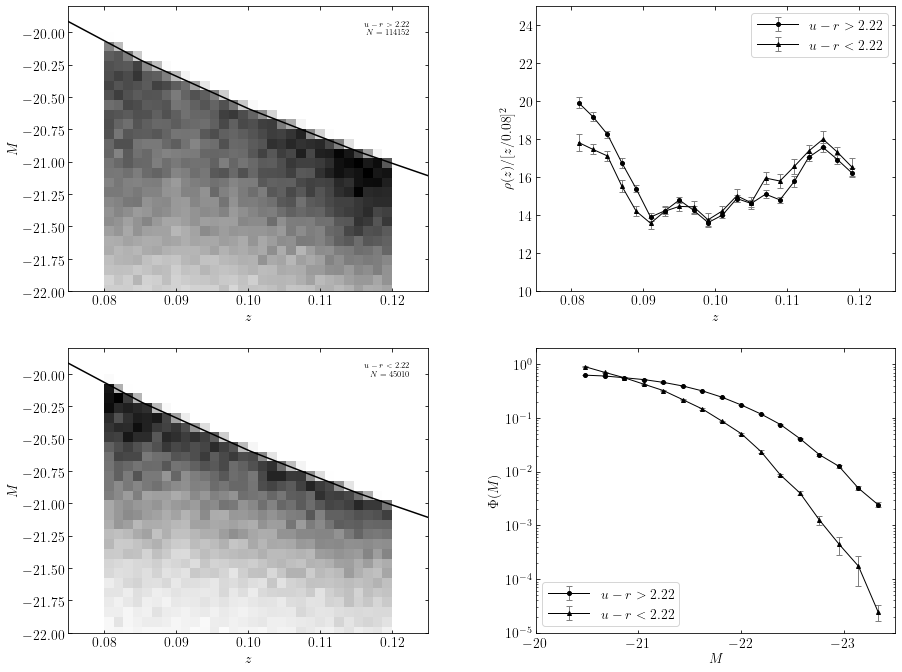

In [35]:
#------------------------------------------------------------
# Perform the computation and plot the results
fig = plt.figure(figsize=(14, 10))
fig.subplots_adjust(left=0.13, right=0.95, wspace=0.3,
                    bottom=0.08, top=0.95, hspace=0.2)

for i in range(2):
    m = data[i]['petroMag_r']
    z = data[i]['z']
    M = m - mu_z(z)

    # compute the luminosity function for the given subsample
    zbins, dist_z, err_z, Mbins, dist_M, err_M = \
        compute_luminosity_function(z, m, M, m_max, archive_files[i])

    #------------------------------------------------------------
    # First axes: plot the observed 2D distribution of (z, M)
    ax = fig.add_subplot(2, 2, 1 + 2 * i)
    H, xbins, ybins = np.histogram2d(z, M, bins=(np.linspace(0.08, 0.12, 31),
                                                 np.linspace(-23, -20, 41)))
    ax.imshow(H.T, origin='lower', aspect='auto',
              interpolation='nearest', cmap=plt.cm.binary,
              extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]))

    # plot the cutoff curve
    zrange = np.linspace(0.07, 0.13, 100)
    Mmax = m_max - mu_z(zrange)
    ax.plot(zrange, Mmax, '-k')

    ax.text(0.95, 0.95, titles[i] + "\n$N = %i$" % len(z),
            ha='right', va='top',
            transform=ax.transAxes)

    ax.set_xlim(0.075, 0.125)
    ax.set_ylim(-22, -19.8)
    ax.set_xlabel('$z$')
    ax.set_ylabel('$M$')

    #------------------------------------------------------------
    # Second axes: plot the inferred 1D distribution in z
    ax2 = fig.add_subplot(2, 2, 2)
    factor = 0.08 ** 2 / (0.5 * (zbins[1:] + zbins[:-1])) ** 2
    ax2.errorbar(0.5 * (zbins[1:] + zbins[:-1]),
                 factor * dist_z, factor * err_z,
                 fmt='-k' + markers[i], ecolor='gray', lw=1, ms=4,
                 label=titles[i])

    #------------------------------------------------------------
    # Third axes: plot the inferred 1D distribution in M
    ax3 = fig.add_subplot(224, yscale='log')

    # truncate the bins so the plot looks better
    Mbins = Mbins[3:-1]
    dist_M = dist_M[3:-1]
    err_M = err_M[3:-1]

    ax3.errorbar(0.5 * (Mbins[1:] + Mbins[:-1]), dist_M, err_M,
                 fmt='-k' + markers[i], ecolor='gray', lw=1, ms=4,
                 label=titles[i])

#------------------------------------------------------------
# set labels and limits
ax2.legend(loc=1)
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.01))
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\rho(z) / [z / 0.08]^2$')
ax2.set_xlim(0.075, 0.125)
ax2.set_ylim(10, 25)

ax3.legend(loc=3)
ax3.xaxis.set_major_locator(plt.MultipleLocator(1.0))
ax3.set_xlabel(r'$M$')
ax3.set_ylabel(r'$\Phi(M)$')
ax3.set_xlim(-20, -23.5)
ax3.set_ylim(1E-5, 2)

plt.show()
